# CSCA 5632 Unsupervised Algorithms in Machine Learning Final Project

In [149]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import RobustScaler

from itertools import permutations

from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import StackingClassifier


In [151]:
data = pd.read_csv("data/loan_default.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

In [153]:
data.describe()

,ID,year,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,Status,dtir1
count,148670.000000,148670.0,1.486700e+05,112231.000000,112031.000000,109028.000000,148629.000000,1.335720e+05,139520.000000,148670.000000,133572.000000,148670.000000,124549.000000
mean,99224.500000,2019.0,3.311177e+05,4.045476,0.441656,3224.996127,335.136582,4.978935e+05,6957.338876,699.789103,72.746457,0.246445,37.732932
std,42917.476598,0.0,1.839093e+05,0.561391,0.513043,3251.121510,58.409084,3.599353e+05,6496.586382,115.875857,39.967603,0.430942,10.545435
min,24890.000000,2019.0,1.650000e+04,0.000000,-3.638000,0.000000,96.000000,8.000000e+03,0.000000,500.000000,0.967478,0.000000,5.000000
25%,62057.250000,2019.0,1.965000e+05,3.625000,0.076000,581.490000,360.000000,2.680000e+05,3720.000000,599.000000,60.474860,0.000000,31.000000
50%,99224.500000,2019.0,2.965000e+05,3.990000,0.390400,2596.450000,360.000000,4.180000e+05,5760.000000,699.000000,75.135870,0.000000,39.000000
75%,136391.750000,2019.0,4.365000e+05,4.375000,0.775400,4812.500000,360.000000,6.280000e+05,8520.000000,800.000000,86.184211,0.000000,45.000000
max,173559.000000,2019.0,3.576500e+06,8.000000,3.357000,60000.000000,360.000000,1.650800e+07,578580.000000,900.000000,7831.250000,1.000000,61.000000


In [155]:
unnecessary_features = ['ID','year']
data.drop(columns=unnecessary_features, inplace=True)
unique_values_dict = {col: data[col].unique() for col in data.columns}

for col, unique_vals in unique_values_dict.items():
    print(f"Unique values in {col}: {unique_vals}")

nan_percentage = data.isna().mean() * 100


print(nan_percentage)

display(data.head())

Unique values in loan_limit: ['cf' nan 'ncf']
Unique values in Gender: ['Sex Not Available' 'Male' 'Joint' 'Female']
Unique values in approv_in_adv: ['nopre' 'pre' nan]
Unique values in loan_type: ['type1' 'type2' 'type3']
Unique values in loan_purpose: ['p1' 'p4' 'p3' 'p2' nan]
Unique values in Credit_Worthiness: ['l1' 'l2']
Unique values in open_credit: ['nopc' 'opc']
Unique values in business_or_commercial: ['nob/c' 'b/c']
Unique values in loan_amount: [ 116500  206500  406500  456500  696500  706500  346500  266500  376500
  436500  136500  466500  226500   76500  356500  156500  586500  306500
  316500  336500  426500  476500  196500  186500  246500  216500  506500
  656500  256500  396500  166500  236500  866500  416500  386500  596500
  606500   86500  286500  146500  446500  636500  486500  326500   56500
  906500  496500  106500  126500  296500  176500 1376500  566500  686500
  556500  676500  366500  276500  716500   66500  616500   96500  826500
   26500  666500  546500  986

,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,loan_amount,rate_of_interest,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,116500,NaN,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,cf,Male,nopre,type2,p1,l1,nopc,b/c,206500,NaN,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,cf,Male,pre,type1,p1,l1,nopc,nob/c,406500,4.56,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,cf,Male,nopre,type1,p4,l1,nopc,nob/c,456500,4.25,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,cf,Joint,pre,type1,p1,l1,nopc,nob/c,696500,4.00,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


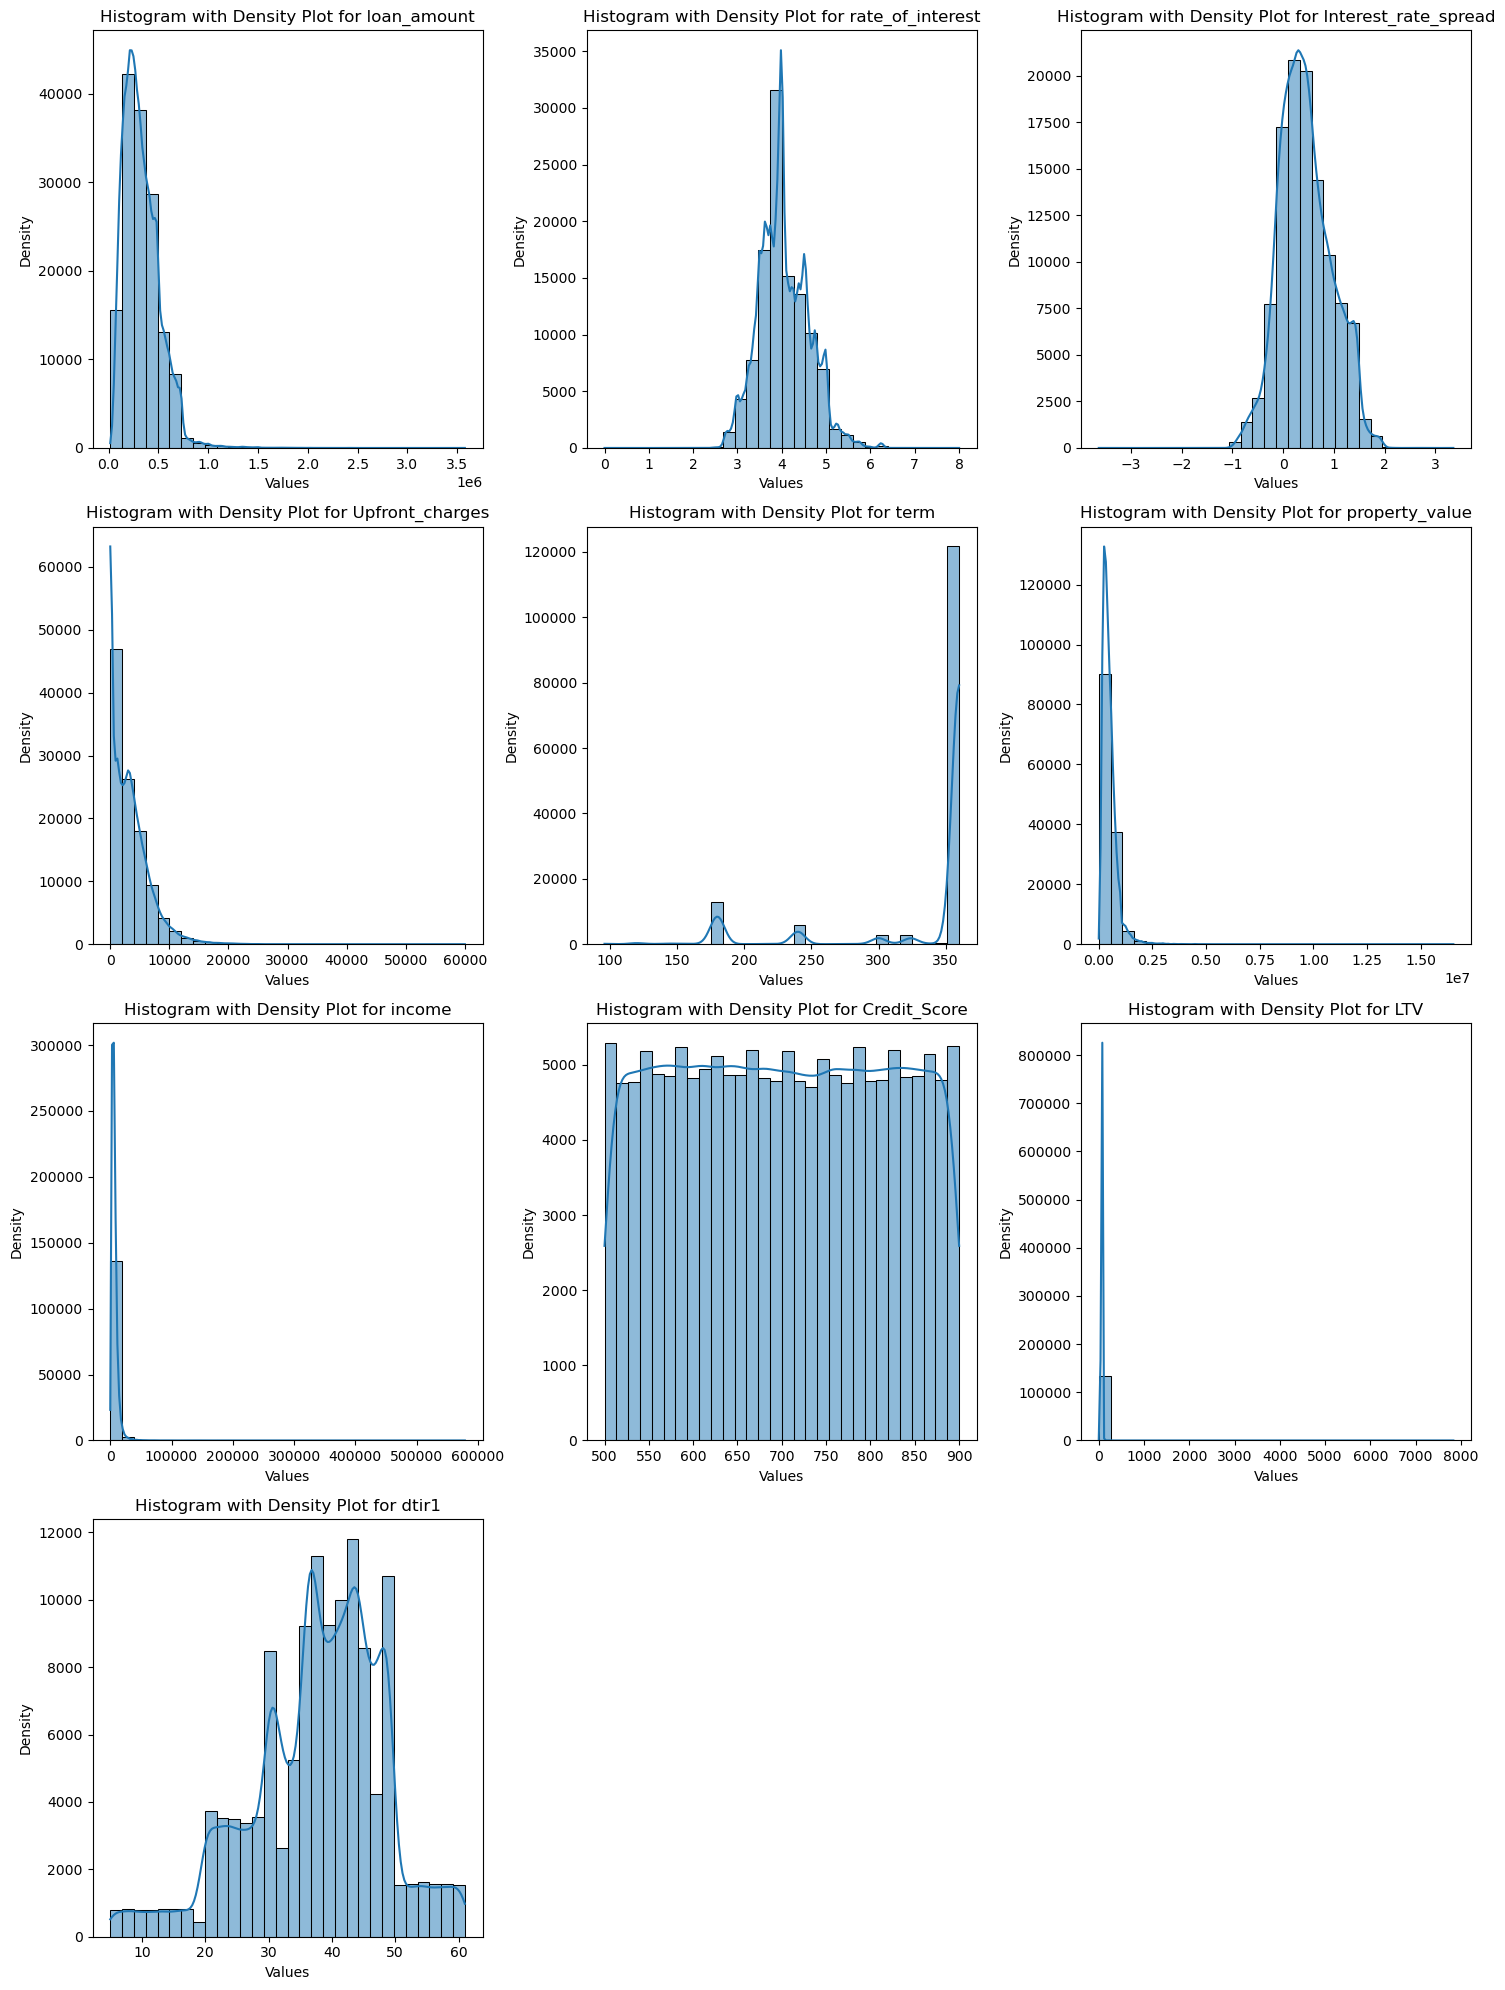

In [157]:
# Plot histograms for each numeric feature in one chart
numeric_data = data.select_dtypes(include=['number']).drop(columns=['Status'])
num_features = numeric_data.shape[1]
num_cols = 3
num_rows = (num_features + num_cols - 1) // num_cols

plt.figure(figsize=(15, num_rows * 5))

for i, feature in enumerate(numeric_data.columns, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.histplot(numeric_data[feature], bins=30, kde=True, edgecolor='black')
    plt.xlabel('Values')
    plt.ylabel('Density')
    plt.title(f'Histogram with Density Plot for {feature}')

plt.tight_layout()
plt.show()

## Comments
Determine how much of the data consists of NaNs by column

In [160]:
data.isnull().sum()

loan_limit                    3344
Gender                           0
approv_in_adv                  908
loan_type                        0
loan_purpose                   134
Credit_Worthiness                0
open_credit                      0
business_or_commercial           0
loan_amount                      0
rate_of_interest             36439
Interest_rate_spread         36639
Upfront_charges              39642
term                            41
Neg_ammortization              121
interest_only                    0
lump_sum_payment                 0
property_value               15098
construction_type                0
occupancy_type                   0
Secured_by                       0
total_units                      0
income                        9150
credit_type                      0
Credit_Score                     0
co-applicant_credit_type         0
age                            200
submission_of_application      200
LTV                          15098
Region              

In [162]:

# Calculate the percentage of missing values for each column
missing_percentage = (data.isnull().sum() / len(data)) * 100

# Print the percentage of missing values for each column
print(missing_percentage)

loan_limit                    2.249277
Gender                        0.000000
approv_in_adv                 0.610749
loan_type                     0.000000
loan_purpose                  0.090133
Credit_Worthiness             0.000000
open_credit                   0.000000
business_or_commercial        0.000000
loan_amount                   0.000000
rate_of_interest             24.509989
Interest_rate_spread         24.644515
Upfront_charges              26.664425
term                          0.027578
Neg_ammortization             0.081388
interest_only                 0.000000
lump_sum_payment              0.000000
property_value               10.155378
construction_type             0.000000
occupancy_type                0.000000
Secured_by                    0.000000
total_units                   0.000000
income                        6.154571
credit_type                   0.000000
Credit_Score                  0.000000
co-applicant_credit_type      0.000000
age                      

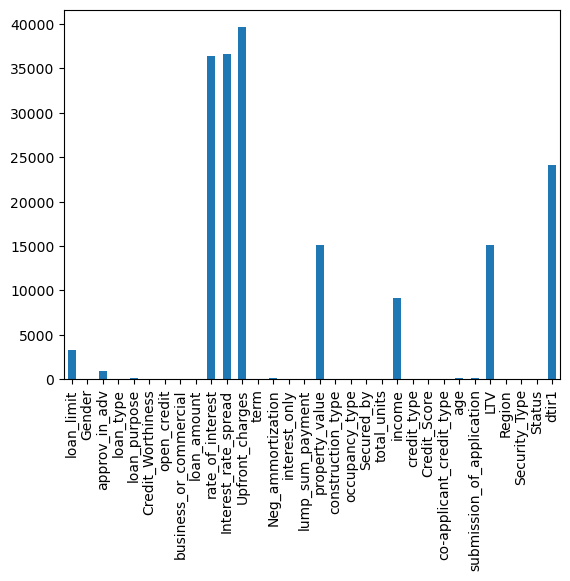

In [164]:
data.isna().sum().plot.bar()
plt.show()

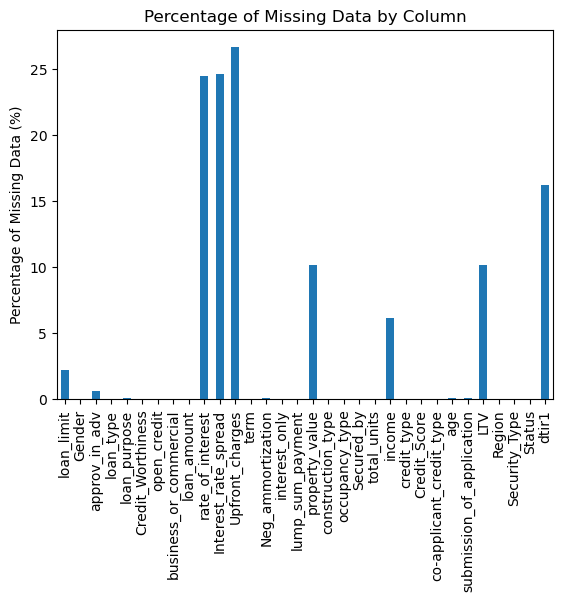

In [166]:
# Calculate the percentage of missing values for each column
missing_percentage = (data.isna().sum() / len(data)) * 100

# Plot the missing percentages as a bar chart
missing_percentage.plot.bar()

# Add labels and title
plt.ylabel('Percentage of Missing Data (%)')
plt.title('Percentage of Missing Data by Column')

# Show the plot
plt.show()

## Clean Up Begins

In [169]:
# drop duplicate
data.drop_duplicates(inplace=True)
data = data.dropna(how='all')

# set a column's datatype as categorical or numeric
categorical_columns = ['loan_limit', 'Gender', 'approv_in_adv', 
                       'loan_type', 'loan_purpose','Credit_Worthiness', 'open_credit',
                       'business_or_commercial','term','Neg_ammortization','interest_only',
                       'lump_sum_payment','Neg_ammortization','construction_type',
                       'occupancy_type','Secured_by','total_units','credit_type',
                       'co-applicant_credit_type','age','submission_of_application','Region',
                       'Security_Type'
                       ]
numerical_columns = ['Status','loan_amount', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'property_value', 'income', 'Credit_Score', 'LTV', 'dtir1']

In [171]:
# missing values with mode
for column in categorical_columns:
    if column in data.columns:
        data[column] = data[column].fillna(data[column].mode()[0])

# missing values with median
for column in numerical_columns:
    if column in data.columns:
        data[column] = data[column].fillna(data[column].median())

# Replace outliers with median
for column in numerical_columns:
    if column in data.columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        median = data[column].median()
        data[column] = np.where((data[column] < lower_bound) | (data[column] > upper_bound), median, data[column])

    
# Use one-hot encoding to convert categorical variables into numerical format.
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Encode the target variable 'Status' as numeric.
data['Status'] = data['Status'].astype(int)


# Normalize/scale numerical features
scaler = RobustScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

data['Status'] = data['Status'].astype('category').cat.codes



In [173]:
missing_values = data.isnull().sum()
print(missing_values)
missing_columns = data.isnull().any()
print(missing_columns)
has_nan = data.isnull().values.any()
print(f'Does the DataFrame have any NaN values? {has_nan}')
data.info()


loan_amount                          0
rate_of_interest                     0
Interest_rate_spread                 0
Upfront_charges                      0
property_value                       0
                                    ..
submission_of_application_to_inst    0
Region_North-East                    0
Region_central                       0
Region_south                         0
Security_Type_direct                 0
Length: 74, dtype: int64
loan_amount                          False
rate_of_interest                     False
Interest_rate_spread                 False
Upfront_charges                      False
property_value                       False
                                     ...  
submission_of_application_to_inst    False
Region_North-East                    False
Region_central                       False
Region_south                         False
Security_Type_direct                 False
Length: 74, dtype: bool
Does the DataFrame have any NaN values? False
<cl

In [175]:

data = data[numerical_columns]

correlation_matrix = data.corr()
correlation_with_target = correlation_matrix["Status"].sort_values(ascending=False)
top_corr_features = correlation_with_target.index[1:9]  # Select top 8 correlated features
top_corr_features = top_corr_features.insert(0, "Status")
filtered_corr_matrix = correlation_matrix.loc[top_corr_features, top_corr_features]

print(correlation_with_target.to_string())



Status                 NaN
loan_amount            NaN
rate_of_interest       NaN
Interest_rate_spread   NaN
Upfront_charges        NaN
property_value         NaN
income                 NaN
Credit_Score           NaN
LTV                    NaN
dtir1                  NaN


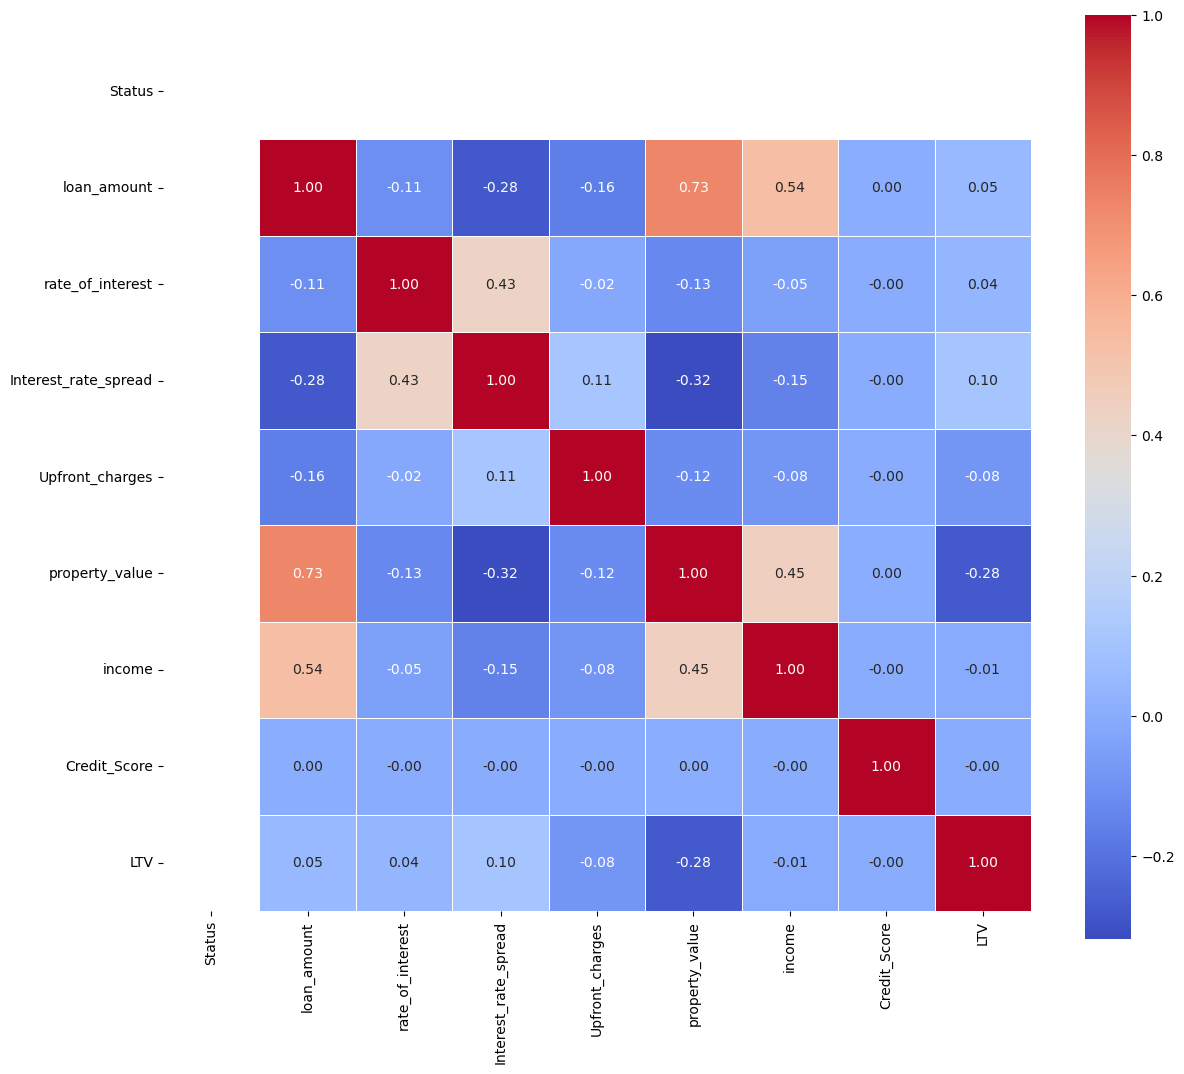

In [177]:
plt.figure(figsize=(14, 12))
sns.heatmap(filtered_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True, linewidths=.5)
plt.show()

In [179]:
top_corr_features

Index(['Status', 'loan_amount', 'rate_of_interest', 'Interest_rate_spread',
       'Upfront_charges', 'property_value', 'income', 'Credit_Score', 'LTV'],
      dtype='object')

In [181]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assume 'data' is your DataFrame and contains the features for PCA
feature_names = features.columns

# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

pca = PCA(n_components=4)  
pca.fit(scaled_features)

# Print the explained variance ratio for each principal component
print("Explained Variance Ratio for each Principal Component:")
for i, variance_ratio in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {variance_ratio:.4f}")

# Print the loadings (importance of each original feature in the principal components)
print("\nLoadings (Importance of Each Feature for Principal Components):")
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=feature_names)
print(loadings)

Explained Variance Ratio for each Principal Component:
PC1: 0.3894
PC2: 0.2501
PC3: 0.2453
PC4: 0.1153

Loadings (Importance of Each Feature for Principal Components):
                       PC1       PC2       PC3       PC4
loan_amount       0.698818  0.008909  0.080449  0.710705
rate_of_interest -0.196377  0.106378  0.971302  0.081811
income            0.687799  0.028119  0.194829 -0.698701
Credit_Score      0.004705 -0.993888  0.110194 -0.004640


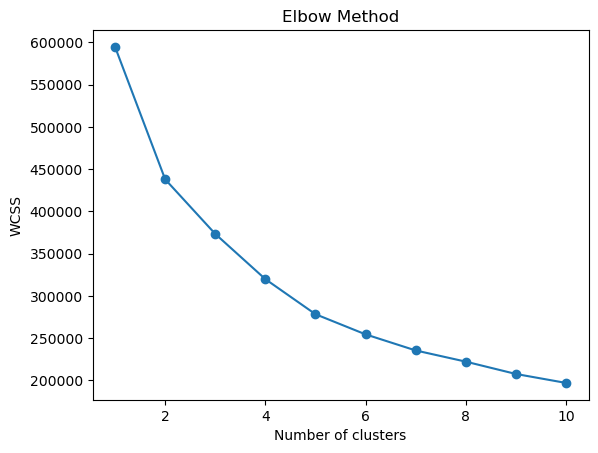

In [215]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(pca_features)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


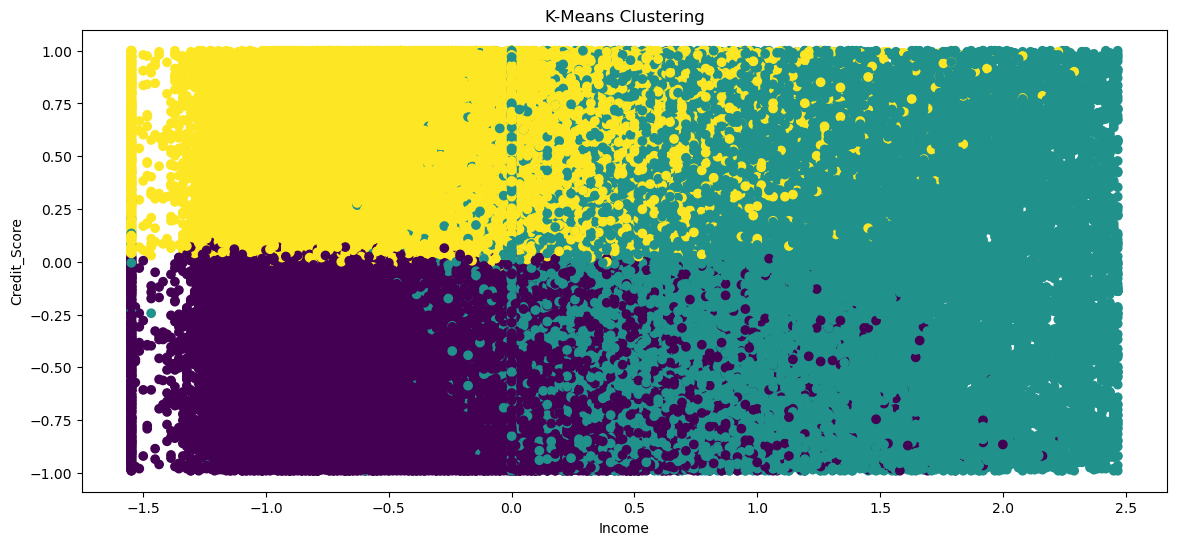

In [213]:
from sklearn.cluster import KMeans


# Select features (excluding non-numeric columns or IDs if necessary)
# features = data
# Select relevant features for clustering
features = data[['loan_amount', 'rate_of_interest', 'income', 'Credit_Score']]


# Apply k-means clustering
kmeans = KMeans(n_clusters=3)
kmeans_labels = kmeans.fit_predict(pca_features)
data['KMeans_Cluster'] = kmeans_labels

# Plot K-Means Clustering
plt.figure(figsize=(14, 6))
plt.scatter(data['income'], data['Credit_Score'], c=data['KMeans_Cluster'])
plt.title('K-Means Clustering')
plt.xlabel('Income')
plt.ylabel('Credit_Score')
plt.show()



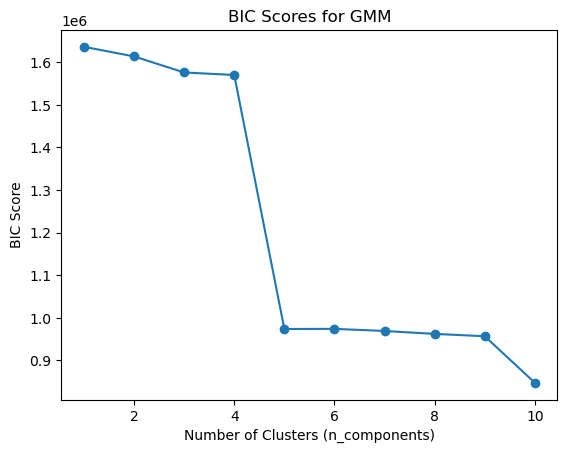

In [200]:
from sklearn.mixture import GaussianMixture

bic_scores = []
n_components_range = range(1, 11)

for n in n_components_range:
    gmm = GaussianMixture(n_components=n)
    gmm.fit(scaled_features)
    bic_scores.append(gmm.bic(scaled_features))

# Plot the BIC scores
plt.plot(n_components_range, bic_scores, marker='o')
plt.title('BIC Scores for GMM')
plt.xlabel('Number of Clusters (n_components)')
plt.ylabel('BIC Score')
plt.show()

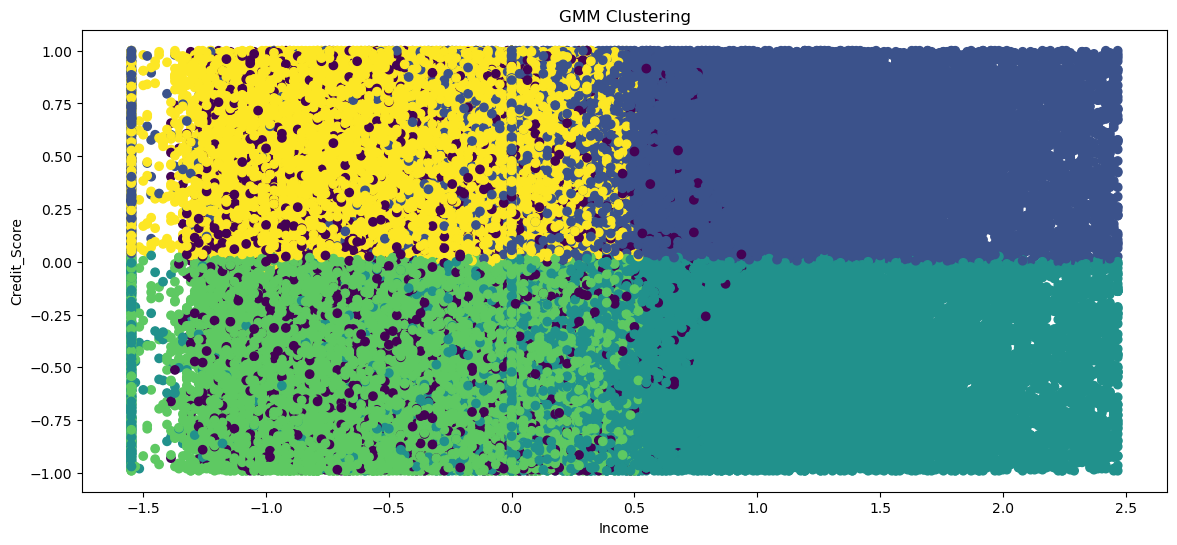

In [209]:
gmm = GaussianMixture(n_components=5)
gmm_labels = gmm.fit_predict(scaled_features)

# Add cluster labels to the original dataframe for both methods
data['GMM_Cluster'] = gmm_labels

# Plot GMM Clustering
plt.figure(figsize=(14, 6))
plt.scatter(data['income'], data['Credit_Score'], c=data['GMM_Cluster'])
plt.title('GMM Clustering')
plt.xlabel('Income')
plt.ylabel('Credit_Score')

plt.show()



In [205]:
from sklearn.metrics import silhouette_score

# Calculate silhouette scores for both models
kmeans_silhouette = silhouette_score(scaled_features, kmeans_labels)
gmm_silhouette = silhouette_score(scaled_features, gmm_labels)

print(f'K-Means Silhouette Score: {kmeans_silhouette:.3f}')
print(f'GMM Silhouette Score: {gmm_silhouette:.3f}')

K-Means Silhouette Score: 0.225
GMM Silhouette Score: 0.186


## Silhouette score
The silhouette score is a metric used to evaluate the quality of clustering results. It measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette score provides an indication of how well each data point has been clustered, and it can be used to assess the overall quality of the clustering.

The **silhouette score** ranges from -1 to +1, and its value indicates the quality of the clustering. Here's how to interpret different ranges of silhouette scores:

### Good Value (Close to +1)
- **Range**: **0.5 to 1**
- **Interpretation**:
  - A score close to **+1** suggests that the clusters are well-separated and compact.
  - Data points are much closer to their own cluster center than to any other cluster center, indicating that the clustering is strong and well-defined.
  - **Typical Scenarios**:
    - Clear, distinct clusters with little overlap.
    - A well-chosen number of clusters.

### Reasonable Value (Around 0 to 0.5)
- **Range**: **0 to 0.5**
- **Interpretation**:
  - A score in this range indicates that the clusters are overlapping or not very distinct.
  - Data points are close to the boundary between clusters, meaning they are not clearly associated with one particular cluster.
  - **Typical Scenarios**:
    - Clusters might be too close to each other, leading to ambiguity in cluster assignments.
    - There might be too many or too few clusters.
    - Data might not naturally cluster well or could be noisy.

### Bad Value (Close to -1)
- **Range**: **-1 to 0**
- **Interpretation**:
  - A score close to **-1** indicates that the clustering is poor.
  - Data points are likely assigned to the wrong clusters because they are closer to points in other clusters than to points in their own cluster.
  - **Typical Scenarios**:
    - The model might have selected an inappropriate number of clusters.
    - The features used for clustering might not effectively separate the data into meaningful groups.
    - The clustering algorithm may not be suitable for the data.

### Summary of Interpretations:
- **Silhouette Score > 0.5**: **Good clustering** with well-separated, compact clusters.
- **0.5 > Silhouette Score > 0**: **Moderate clustering** with some overlap or ambiguity between clusters.
- **Silhouette Score < 0**: **Poor clustering**, where data points are likely misclassified, and clusters are not meaningful.

### Practical Considerations:
- **Data Structure**: The interpretation of a "good" silhouette score can depend on the data. In some complex datasets, a silhouette score around 0.3 might be the best achievable result.
- **Domain-Specific**: What constitutes a "good" score might vary depending on the domain and the specific characteristics of the data being analyzed.
- **Comparative Measure**: Often, silhouette scores are used in a comparative sense—comparing scores across different clustering methods, numbers of clusters, or feature sets, rather than as absolute indicators.

In practice, a silhouette score above 0.5 is typically considered good, but always consider the context and the specific dataset when interpreting this metric.